In [366]:
import time
import torch
from matplotlib import pyplot as plt
from pykeops.torch import LazyTensor
import sys

use_cuda = False # torch.cuda.is_available()
dtype = torch.float32 if use_cuda else torch.float64
device_id = "cuda:0" if use_cuda else "cpu"


In [419]:
import torch
from pykeops.torch import LazyTensor
import time
from pykeops.torch.cluster import cluster_centroids

def KMeans(x, c, Niter=10, verbose=True):
    """Implements Lloyd's algorithm for the Euclidean metric."""

    start = time.time()
    N, D = x.shape  # Number of samples, dimension of the ambient space

    c = c.clone()  # Simplistic initialization for the centroids

    K = c.shape[0]
    x_i = LazyTensor(x.view(N, 1, D))  # (N, 1, D) samples
    c_j = LazyTensor(c.view(1, K, D))  # (1, K, D) centroids


    for i in range(Niter):
        # E step: assign points to the closest cluster -------------------------
        D_ij = ((x_i - c_j) ** 2).sum(-1)  # (N, K) symbolic squared distances
        cl = D_ij.argmin(dim=1).long().view(-1)  # Points -> Nearest cluster

        # M step: update the centroids to the normalized cluster average: ------
        # Compute the sum of points per cluster:
        c_old = c.clone()
        c.zero_()
        c.scatter_add_(0, cl[:, None].repeat(1, D), x)

        # Divide by the number of points per cluster:
        Ncl = torch.bincount(cl, minlength=K).type_as(c).view(K, 1)
        Ncl = torch.max(Ncl, torch.ones_like(Ncl))
        c /= Ncl  # in-place division to compute the average

        diff = (c - c_old).abs().max()

        if not torch.isfinite(diff):
            print("Numerical errors at iteration", i)
            break

        if diff < 1e-5:
            print("Convergence reached in", i, "iterations, within", time.time() - start, "seconds")
            break

        

    return cl, c


In [420]:
N, D, K = 16384, 2, 8
x = 0.7 * torch.randn(N, D, dtype=torch.float32, device='cpu') + 0.3
cl, c = KMeans(x, x[:8192], Niter=2**32)


Convergence reached in 7 iterations, within 0.013646841049194336 seconds


In [398]:
import torch
from pykeops.torch import LazyTensor
import time
from pykeops.torch.cluster import cluster_centroids

def KMeans(x, c, Niter=10, verbose=True):
    """Implements Lloyd's algorithm for the Euclidean metric."""

    start = time.time()
    N, D = x.shape  # Number of samples, dimension of the ambient space

    c = c.clone()  # Simplistic initialization for the centroids
    K = c.shape[0]
    for i in range(Niter):
        # E step: assign points to the closest cluster -------------------------

        d_ij = torch.cdist(x, c)  # (N, K) symbolic squared distances
        cl = d_ij.argmin(dim=1)

        c_old = c.clone()

        # Update the centroids c
        c.zero_()
        c.scatter_add_(0, cl[:, None].expand(-1, D), x)
        Ncl = torch.bincount(cl, minlength=K).type_as(c).view(K, 1)
        Ncl = torch.max(Ncl, torch.ones_like(Ncl))
        c /= Ncl
        
        diff = (c - c_old).abs().max()

        if not torch.isfinite(diff):
            print("Numerical errors at iteration", i)
            break

        if diff < 1e-5:
            break

    return cl, c


In [399]:
%%timeit
N, D, K = 16384, 2, 8
x = 0.7 * torch.randn(N, D, dtype=torch.float32, device=device_id) + 0.3
cl, c = KMeans(x, x[:8192], Niter=2**32)


1.15 s ± 246 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


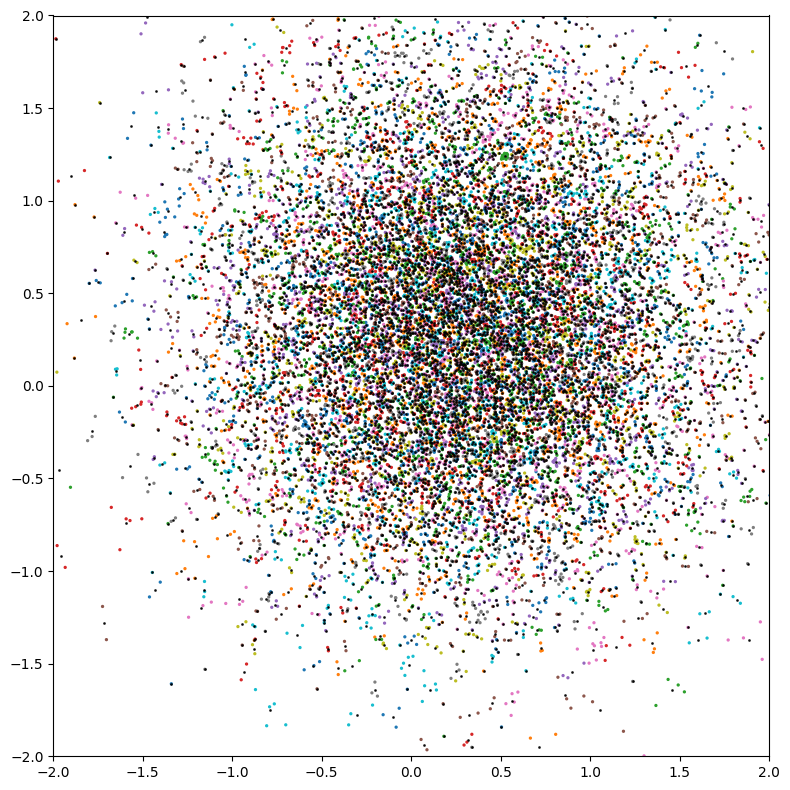

In [400]:
plt.figure(figsize=(8, 8))
plt.scatter(x[:, 0].cpu(), x[:, 1].cpu(), c=cl.cpu(), s=30000 / len(x), cmap="tab10")
plt.scatter(c[:, 0].cpu(), c[:, 1].cpu(), c="black", s=1, alpha=0.8)
plt.axis([-2, 2, -2, 2])
plt.tight_layout()
plt.show()

In [401]:
import torch
from pykeops.torch import LazyTensor
import time
from pykeops.torch.cluster import from_matrix


def farthest_points(x, n):
    N, D = x.shape  # Number of samples, dimension of the ambient space
    centroids = torch.zeros(n, D, dtype=x.dtype, device=x.device)
    centroid = x.mean(0)

    distance = torch.full((N,), float("inf"), dtype=x.dtype, device=x.device)
    for i in range(n):
        centroids[i] = centroid
        d_ij = torch.square(x - centroid).sum(-1)
        mask = d_ij < distance
        distance[mask] = d_ij[mask]
        centroid = x[distance.argmax()]
    return centroids



        


In [326]:
N = 1024
x = 0.7 * torch.randn(N, D, dtype=dtype, device=device_id) + 0.3
c = farthest_points(x, 512)

cl, c = KMeans(x, c, Niter=2 ** 32, verbose=True)

/tmp/ipykernel_2600347/2509609534.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x[:, 0].cpu(), x[:, 1].cpu(), s=30000 / len(x), cmap="tab10")


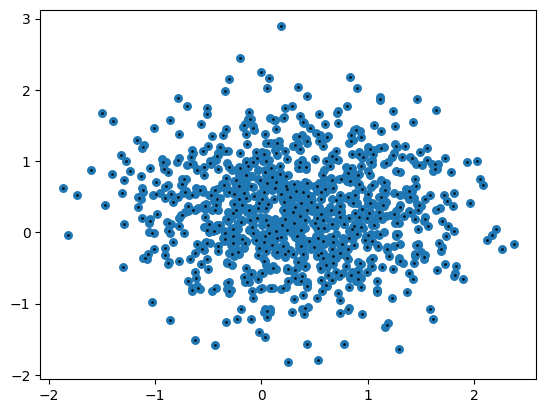

In [327]:
plt.scatter(x[:, 0].cpu(), x[:, 1].cpu(), s=30000 / len(x), cmap="tab10")
plt.scatter(c[:, 0].cpu(), c[:, 1].cpu(), c="black", s=1, alpha=0.8)

In [271]:
import torch
from pykeops.torch import LazyTensor
import time
from pykeops.torch.cluster import from_matrix

# from pykeops.numpy.cluster import from_matrix

# ranges_ij = from_matrix(x_ranges, y_ranges, keep)


def FarthestPoint(x, n, verbose=True):

    start = time.time()
    N, D = x.shape  # Number of samples, dimension of the ambient space

    # c = x[:K, :].clone()  # Simplistic initialization for the centroids
    centroids = torch.zeros(n, D, dtype=x.dtype, device=x.device)
    x = torch.cat([x.mean(0, keepdim=True), x], dim=0)
    cdist = torch.cdist(x, x)
    idx = 0

    for i in range(1, n):
        new_idx = cdist[idx].argmax()

        centroids[i] = x[idx]

        cdist[idx] = 0
        cdist[:, idx] = 0

        idx = new_idx

    return centroids






        


In [277]:
%%timeit
N = 1024
x = 0.7 * torch.randn(N, D, dtype=dtype, device=device_id) + 0.3
c = FarthestPoint(x, 512)

27.8 ms ± 13.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


/tmp/ipykernel_2600347/2509609534.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x[:, 0].cpu(), x[:, 1].cpu(), s=30000 / len(x), cmap="tab10")


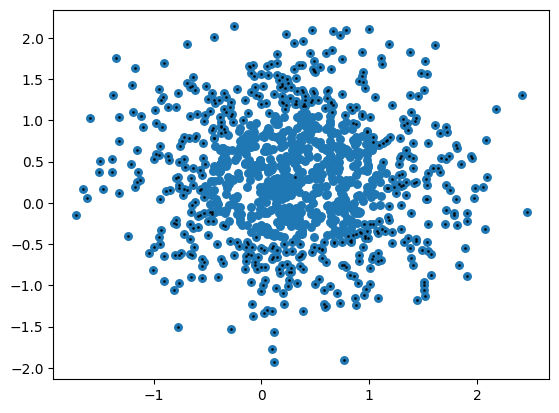

In [278]:
plt.scatter(x[:, 0].cpu(), x[:, 1].cpu(), s=30000 / len(x), cmap="tab10")
plt.scatter(c[:, 0].cpu(), c[:, 1].cpu(), c="black", s=1, alpha=0.8)

In [365]:
from fast_pytorch_kmeans import KMeans
import torch

kmeans = KMeans(n_clusters=8192, mode='euclidean', verbose=1)
x = torch.randn(16384, 3, device='cpu')
labels = kmeans.fit_predict(x)


used 7 iterations (2.3233s) to cluster 16384 items into 8192 clusters


In [5]:
import sklearn
import numpy as np

data = np.random.randn(1024, 3)

In [8]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=512, random_state=0, n_init=1).fit(data)
kmeans.cluster_centers_


InvalidParameterError: The 'n_init' parameter of KMeans must be a str among {'auto'} or an int in the range [1, inf). Got 0 instead.